# 3. Implementing a GPT model from Scratch to generate text

In [1]:
import torch
from torch import nn

In [2]:
GPT_CONFIG_124M = {
"vocab_size": 50257, # Vocabulary size
"context_length": 1024, # Context length
"emb_dim": 768,# Embedding dimension
"n_heads": 12,# Number of attention heads
"n_layers": 12,# Number of layers
"drop_rate": 0.1,# Dropout rate
"qkv_bias": False# Query-Key-Value bias
}

In [3]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps = 1e-5):
        super().__init__()
    
    def forward(self, x):
        return x



class DummyGPtModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = DummyLayerNorm(cfg["emb_dim"])

        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)


    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape

        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)

        x = self.trf_blocks(x)

        x = self.final_norm(x)

        logits = self.out_head(x)

        return logits





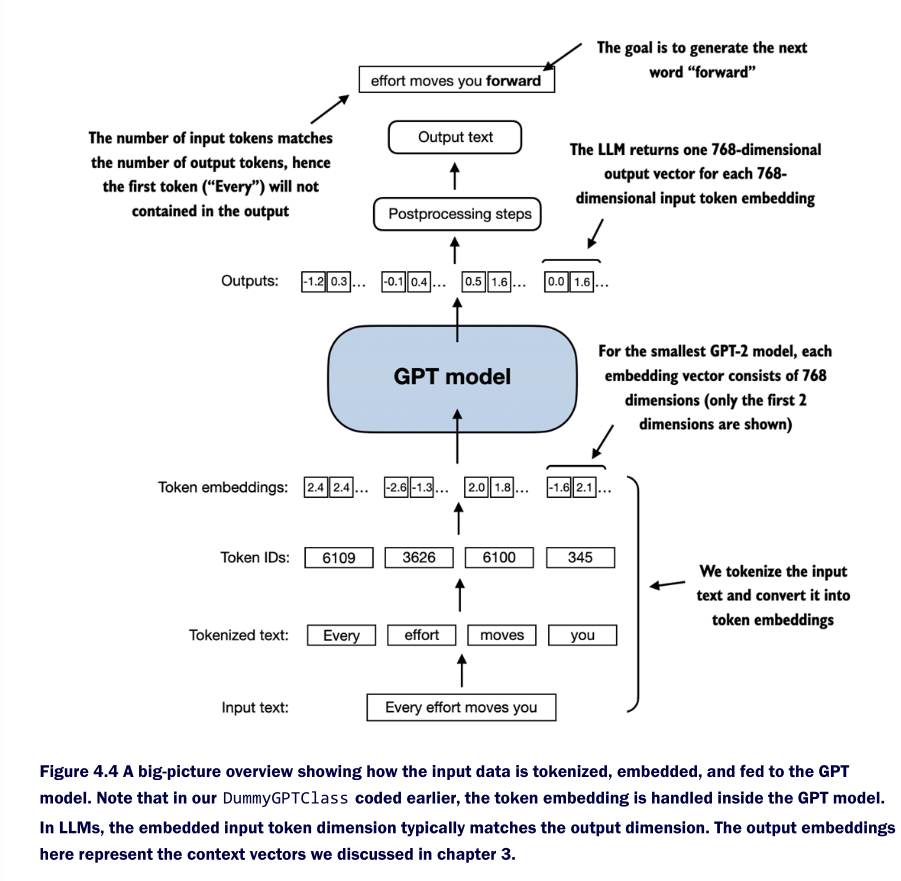

In [4]:
import tiktoken

In [5]:
tokenizer = tiktoken.get_encoding("gpt2")

In [6]:
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

In [7]:
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch

[tensor([6109, 3626, 6100,  345]), tensor([6109, 1110, 6622,  257])]

In [8]:
batch = torch.stack(batch, dim=0)
batch

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [9]:
torch.manual_seed(123)
model = DummyGPtModel(GPT_CONFIG_124M)
logits = model(batch)

print("Output shape: ", logits.shape)
logits

Output shape:  torch.Size([2, 4, 50257])


tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)

The main idea behind layer normalization is to adjust the activations (outputs) of a
neural network layer to have a mean of 0 and a variance of 1, also known as unit variance.
This adjustment speeds up the convergence to effective weights and ensures consistent,
reliable training. As we have seen in the previous section, based on the `DummyLayerNorm`
placeholder, in GPT-2 and modern transformer architectures, layer normalization is typically
applied before and after the multi-head attention module and before the final output layer.

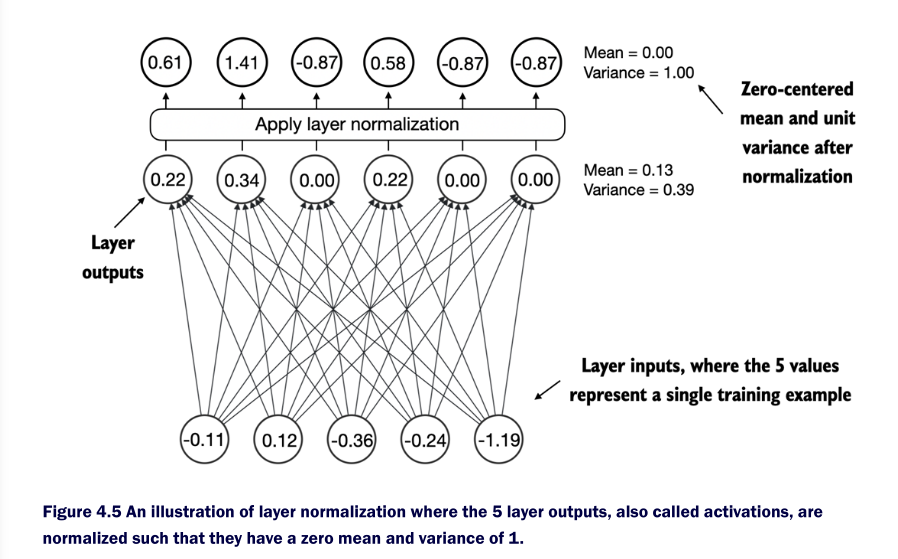

In [10]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)

print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [11]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean: ", mean)
print("Variance: ", var)

Mean:  tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:  tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [12]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


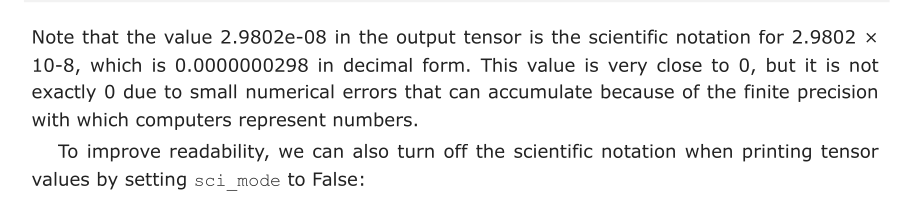

In [13]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [14]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim= -1, keepdim= True)
        var = x.var(dim= -1, keepdim = True, unbiased = False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift



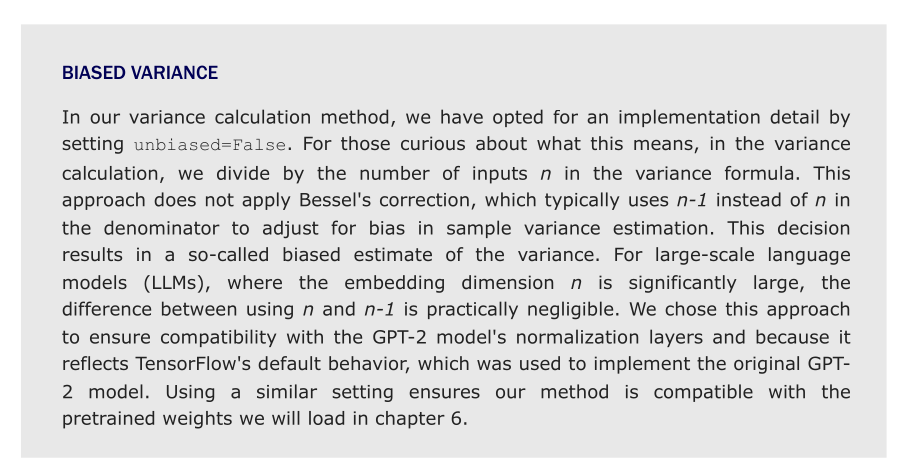

In [15]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

mean = out_ln.mean(dim=-1, keepdim = True)
var = out_ln.var(dim=-1, unbiased= False, keepdim = True)

print(f"Mean: {mean}")
print(f"Variance: {var}")



Mean: tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


#### Layer Normalization vs Batch Normalization
If you are familiar with batch normalization, a common and traditional normalization
method for neural networks, you may wonder how it compares to layer
normalization. Unlike batch normalization, which normalizes across the batch
dimension, layer normalization normalizes across the feature dimension. LLMs often
require significant computational resources, and the available hardware or the
specific use case can dictate the batch size during training or inference. Since layer
normalization normalizes each input independently of the batch size, it offers more
flexibility and stability in these scenarios. This is particularly beneficial for distributed
training or when deploying models in environments where resources are constrained.

### Implementing a feed forward network with GELU activations

Historically, the ReLU activation function has been commonly used in deep learning due
to its simplicity and effectiveness across various neural network architectures. However, in
LLMs, several other activation functions are employed beyond the traditional ReLU. Two
notable examples are GELU (Gaussian Error Linear Unit) and SwiGLU (Swish-Gated Linear
Unit)


GELU and SwiGLU are more complex and smooth activation functions incorporating
Gaussian and sigmoid-gated linear units, respectively. They offer improved performance for
deep learning models, unlike the simpler ReLU.

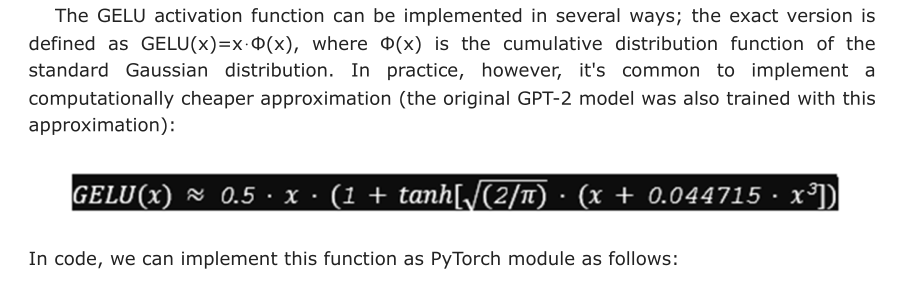

In [16]:
class GELU(nn.Module):
    def __init__(self ):
        super().__init__()

        
    def forward(self, x):
        return 0.5 * x  *(1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0) / (torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))
    


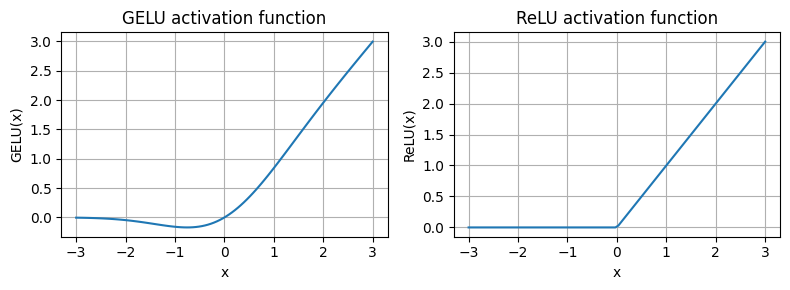

In [17]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()


x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

The smoothness of GELU, as shown in Figure 4.8, can lead to better optimization properties
during training, as it allows for more nuanced adjustments to the model's parameters. In
contrast, ReLU has a sharp corner at zero, which can sometimes make optimization harder,
especially in networks that are very deep or have complex architectures. Moreover, unlike
RELU, which outputs zero for any negative input, GELU allows for a small, non-zero output
for negative values. This characteristic means that during the training process, neurons that
receive negative input can still contribute to the learning process, albeit to a lesser extent
than positive inputs.

#### FeedForward 

In [18]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [19]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)

print(out.shape)

torch.Size([2, 3, 768])


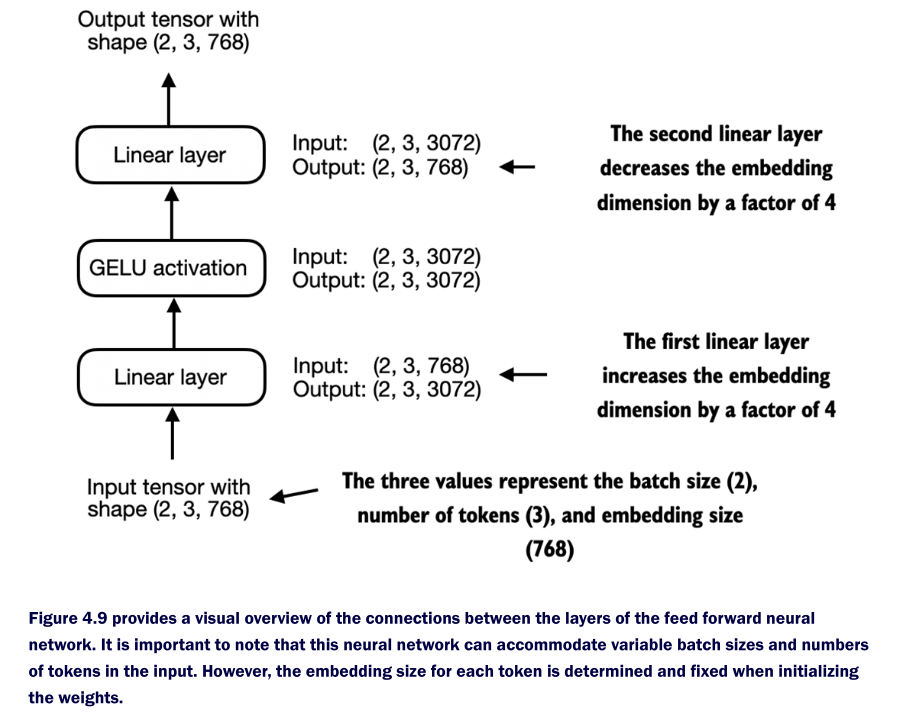

### Adding shortcut connections (residual connection)

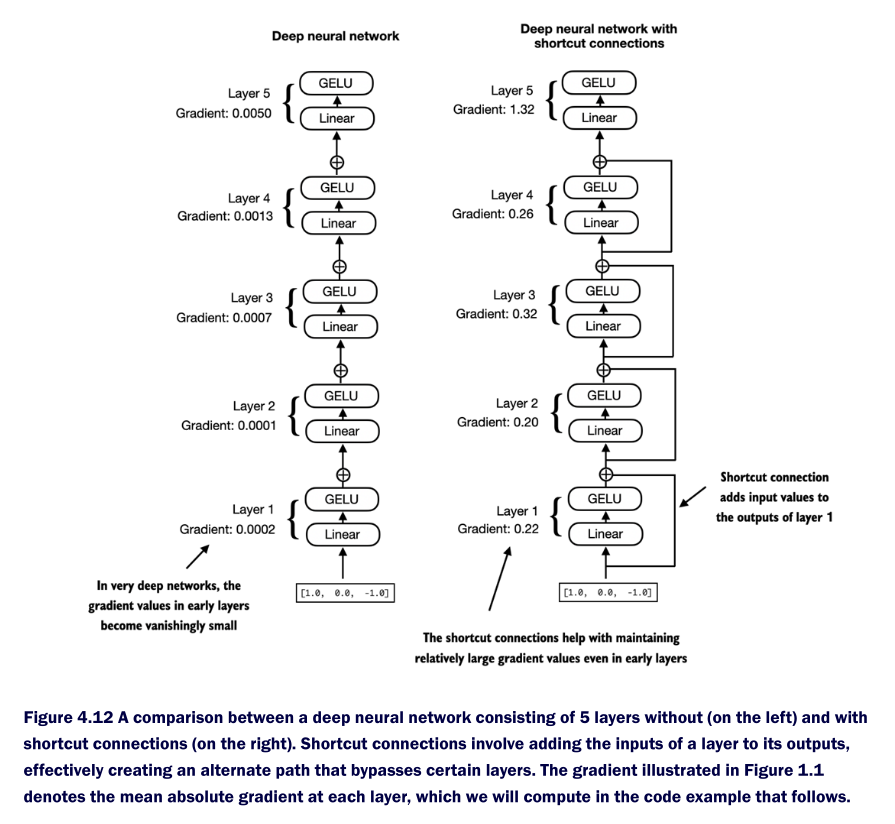

In [20]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
# Implement 5 layers
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
            ])
    def forward(self, x):
        for layer in self.layers:
        # Compute the output of the current layer
            layer_output = layer(x)
        # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                    x = layer_output
        return x

In [21]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])


torch.manual_seed(123) # specify random seed for the initial weights for reproducibility


model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

In [22]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])
    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    # Backward pass to calculate the gradients
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
        # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [23]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [24]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694108307361603
layers.2.0.weight has gradient mean of 0.3289699852466583
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472


In [25]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // self.num_heads #A
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)

        self.out_proj = nn.Linear(d_out, d_out) #B

        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    
    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) #C
        values = self.W_value(x)
        queries = self.W_query(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) #D
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2) #E -> (b, num_heads, num_tokens, head_dim)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3) # F 
        # (b, num_heads, num_tokens, head_dim) @ (b, num_heads, head_dim, num_tokens)
        # -> (b, num_heads, num_tokens, num_tokens)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2) #I

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) #J
        context_vec = self.out_proj(context_vec) #K

        return context_vec

#A Reduce the projection dim to match desired output dim
#B Use a Linear layer to combine head outputs
#C Tensor shape: (b, num_tokens, d_out)
#D We implicitly split the matrix by adding a `num_heads` dimension. Then we unroll last dim: (b,
# num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
#E Transpose from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)
#F Compute dot product for each head
#G Mask truncated to the number of tokens
#H Use the mask to fill attention scores
#I Tensor shape: (b, num_tokens, n_heads, head_dim)
#J Combine heads, where self.d_out = self.num_heads * self.head_dim
#K Add an optional linear projection



In [26]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in= cfg["emb_dim"],
            d_out= cfg["emb_dim"],
            context_length= cfg["context_length"],
            num_heads= cfg["n_heads"],
            dropout= cfg["drop_rate"],
            qkv_bias= cfg["qkv_bias"]
        )

        self.ff = FeedForward(cfg)

        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])

        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        
        x = self.att(x)
        
        x = self.drop_shortcut(x)
        
        x = x + shortcut

        shortcut = x 

        x = self.norm2(x)

        x = self.ff(x)

        x = self.drop_shortcut(x)

        x = x + shortcut
        return x

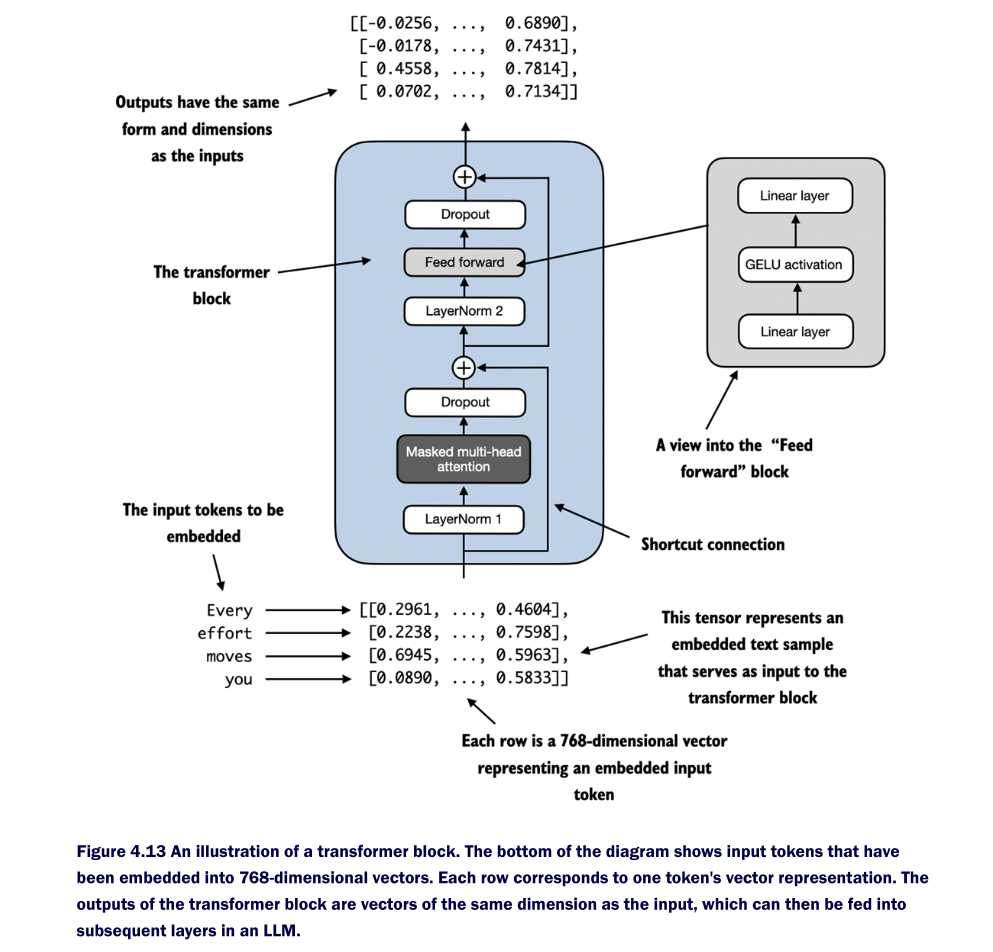

In [27]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)

block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print(f"input shape: {x.shape}")
print(f"output shape: {output.shape}")



input shape: torch.Size([2, 4, 768])
output shape: torch.Size([2, 4, 768])


## Coding the GPT Model

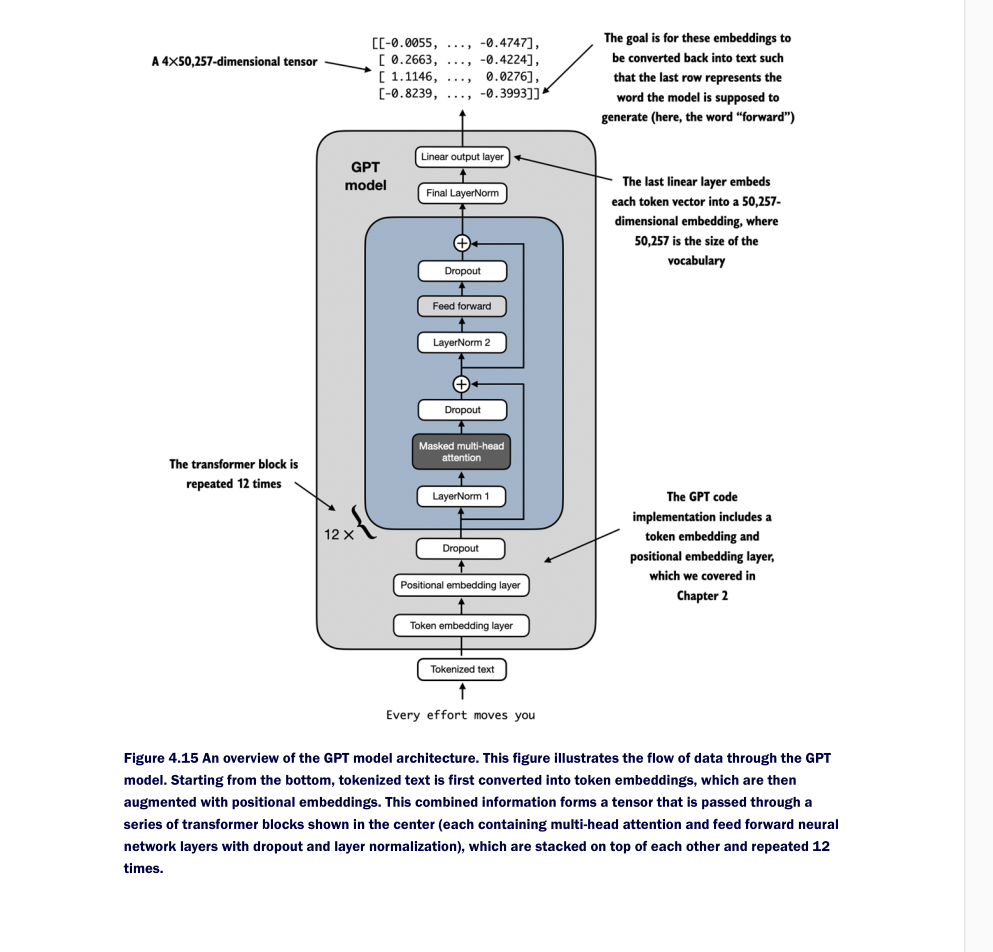

In [28]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds

        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

        

In [29]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)

out = model(batch)

print(f"Input batch: {batch}")

print(f"Output shape: {out.shape}")

print(out)

Input batch: tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.6561,  0.4161,  0.3106,  ..., -0.3366, -0.7138, -0.4810],
         [ 0.8256, -0.8956, -0.6054,  ..., -0.6549, -0.7380, -0.3293],
         [ 0.2418,  0.0977, -0.6100,  ..., -0.1347, -0.9565, -0.6104],
         [-0.9772,  0.5281, -0.4403,  ...,  0.8215,  0.0260, -0.5255]],

        [[-0.5236,  0.5292, -0.0881,  ..., -0.7075, -0.6918, -0.0684],
         [ 0.1366, -0.0487,  0.2687,  ...,  0.2376, -0.6059,  0.4007],
         [ 0.6428,  0.7841, -0.2196,  ..., -0.0206,  0.0761, -0.1708],
         [-0.4154, -0.0512,  0.2661,  ...,  0.8325, -0.6700,  0.1015]]],
       grad_fn=<UnsafeViewBackward0>)


In [30]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


The reason is a concept called **weight tying** that is used in the original GPT-2
architecture, which means that the original GPT-2 architecture is reusing the weights from
the token embedding layer in its output layer. To understand what this means, let's take a
look at the shapes of the token embedding layer and linear output layer that we initialized
on the model via the GPTModel earlier:

In [31]:
print("Token embedding layer shape:", model.tok_emb.weight.shape) #TODO: See what is weight tying
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


The token embedding and output layers are very large due to the number of rows for the
50,257 in the tokenizer's vocabulary. Let's remove the output layer parameter count from
the total GPT-2 model count according to the weight tying:

In [32]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [33]:
print("number of parameters contained in feed forward module!")
sum(p.numel() for p in block.ff.parameters())

number of parameters contained in feed forward module!


4722432

In [34]:
print("number of parameters contained in multi-head attention module:")

sum(p.numel() for p in block.att.parameters())

number of parameters contained in multi-head attention module:


2360064

In [35]:
total_size_bytes = total_params * 4 #A Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_mb = total_size_bytes / (1024 * 1024)#B Convert to megabytes
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


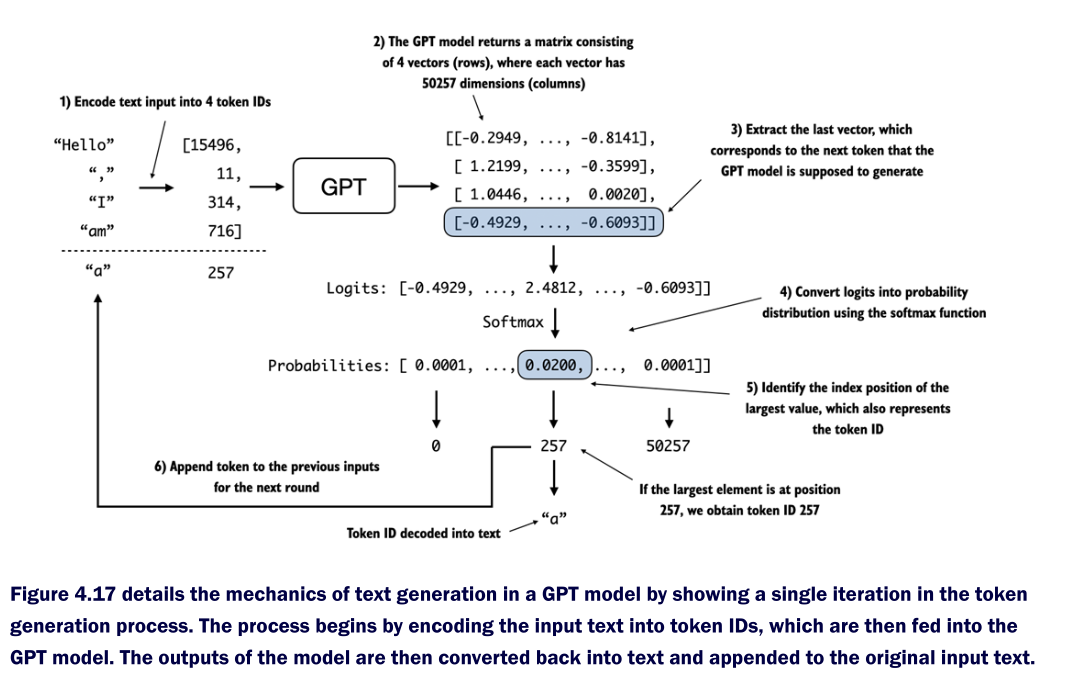

It's predict word sequentially TODO: Can we predict next word without the previous word?


Finally, this token is appended to the previous inputs, forming a new input sequence for the
subsequent iteration. This step-by-step process enables the model to generate text
sequentially, building coherent phrases and sentences from the initial input context.


In practice, we repeat this process over many iterations, such as shown in Figure 4.16
earlier, until we reach a user-specified number of generated tokens.

In [36]:
def generate_text_simple(model, idx, max_new_tokens, context_size): #A
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] #B (just use context_size last token)
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :] #C
        probas = torch.softmax(logits, dim=-1) #D
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) #E
        idx = torch.cat((idx, idx_next), dim=1) #F
    return idx

#A idx is a (batch, n_tokens) array of indices in the current context
#B Crop current context if it exceeds the supported context size E.g., if LLM supports only 5 tokens, and the
#context size is 10 then only the last 5 tokens are used as context
#C Focus only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)
#D probas has shape (batch, vocab_size)
#E idx_next has shape (batch, 1)
#F Append sampled index to the running sequence, where idx has shape (batch, n_tokens+1)

In [37]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [38]:
model.eval()

out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens=6, 
    context_size= GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 37532, 49980,  1114, 46546, 23696, 49073]])
Output length: 10


In [39]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
decoded_text

'Hello, I am Ae thefts For Droid analyticsAbyss'

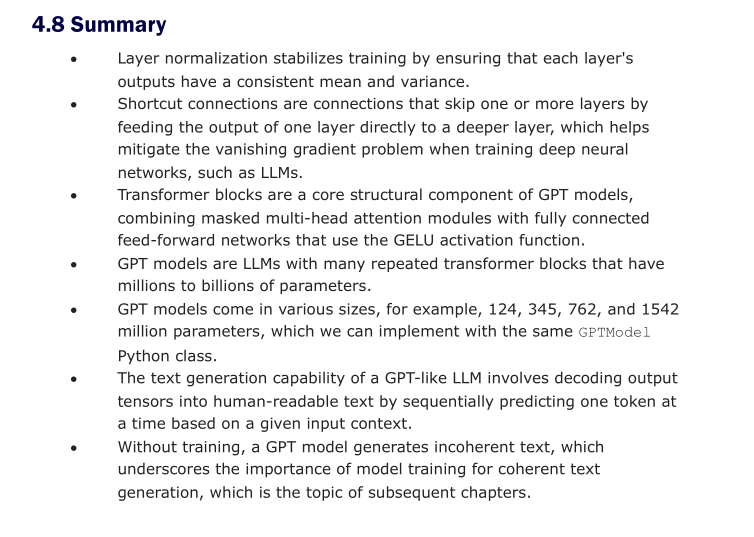

# 4. Pretraining on Unlabeled Data

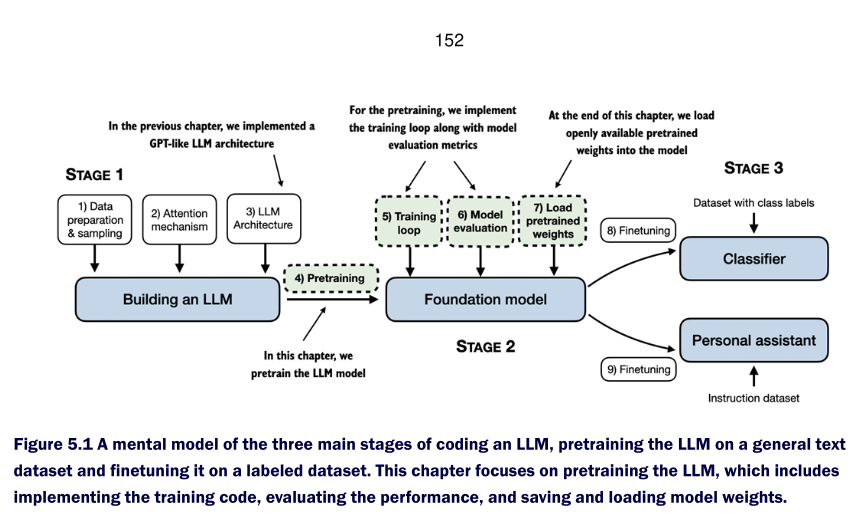

## 4.1 Evaluating generative text models

In [40]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, #A shorter than previous chapter (1024 to 256)
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1, #B
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

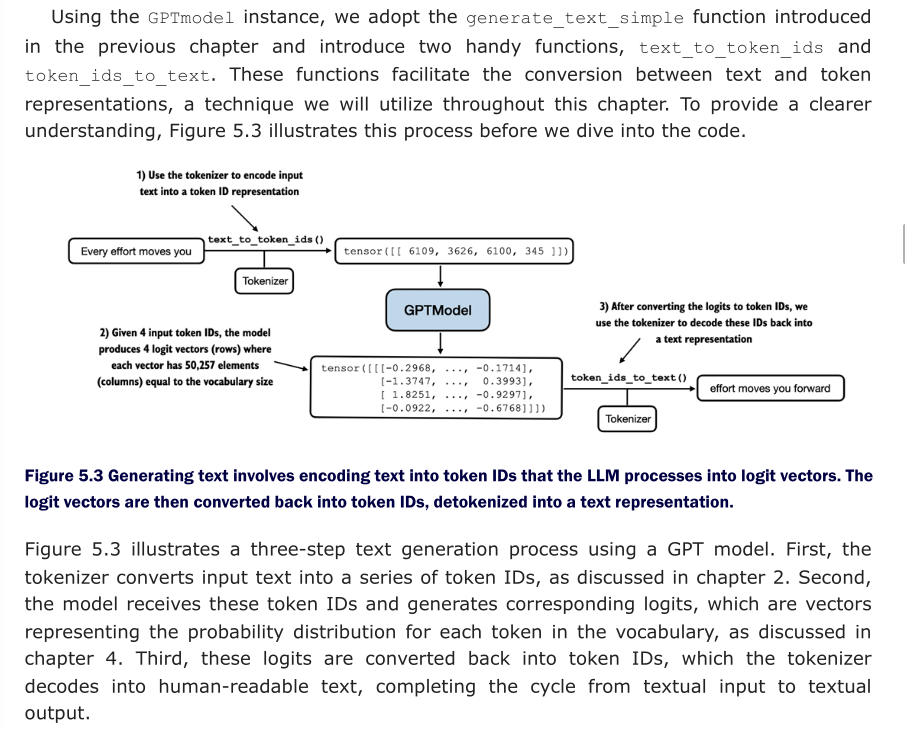

In [41]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimention
    return tokenizer.decode(flat.tolist())


In [42]:
start_context = "Every effort moves you"
start_context

'Every effort moves you'

In [43]:
tokenizer = tiktoken.get_encoding("gpt2")

In [44]:
token_ids = generate_text_simple(
    model=model,
    idx= text_to_token_ids(start_context, tokenizer=tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:")
print(token_ids_to_text(token_ids=token_ids, tokenizer=tokenizer))

Output:
Every effort moves you 960esame WindsorFE Keith awaitedSer seriously Estimated stren


Based on the output, it's clear the model isn't yet producing coherent text because it hasn't
undergone training. To define what makes text "coherent" or "high quality," we have to
implement a numerical method to evaluate the generated content. This approach will
enable us to monitor and enhance the model's performance throughout its training process.


The following section introduces how we calculate a loss metric for the generated
outputs. This loss serves as a progress and success indicator of the training progress.
Furthermore, in subsequent chapters on finetuning LLMs, we will review additional
methodologies for assessing model quality.

### Calculating the text generation loss

In [45]:
inputs = torch.tensor(
                    [[16833, 3626, 6100], # every effort moves 
                    [40,1107, 588]]) #"I really like"

targets = torch.tensor([[3626, 6100, 345], # effort moves you
                        [107, 588, 11311]]) # really like chocolate



In [46]:
with torch.inference_mode():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1) # probability of each token in vocabulary
print(probas.shape)

torch.Size([2, 3, 50257])


In [47]:
probas

tensor([[[    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000]],

        [[    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000]]])

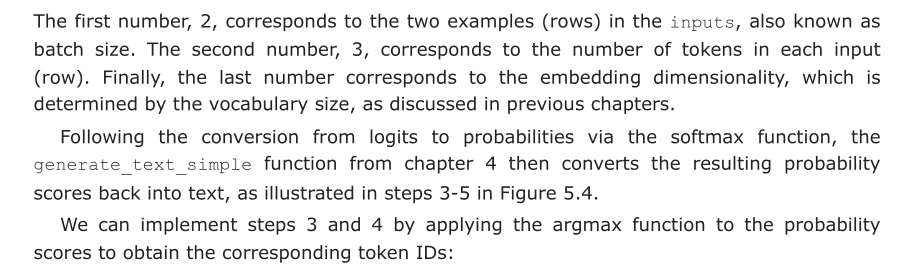

In [48]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[13207],
         [  552],
         [42826]],

        [[18236],
         [ 1775],
         [ 7055]]])


In [50]:
print(f"targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Output batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")


targets batch 1:  effort moves you
Output batch 1: hole compNetflix


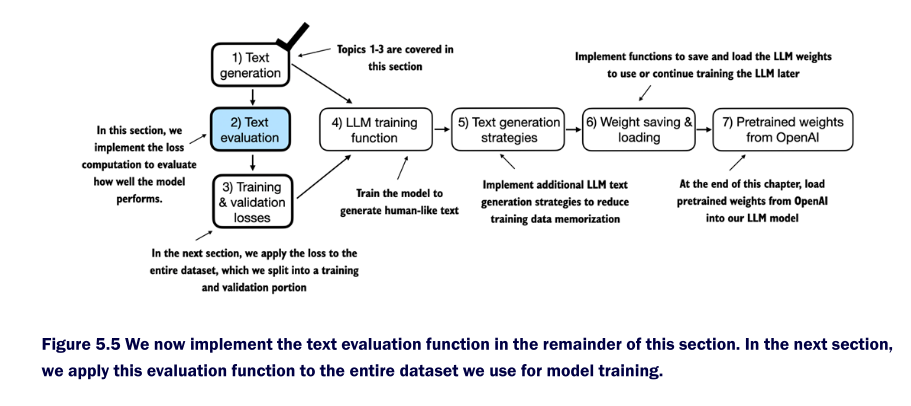

Part of the text evaluation process that we implement in the remainder of this section, as
shown in Figure 5.5, is to measure "how far" the generated tokens are from the correct
predictions (targets). The training function we implement later in this chapter will use this
information to adjust the model weights to generate text that is more similar to (or ideally
matches) the target text.

In [51]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([    0.0001,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0000,     0.0000])


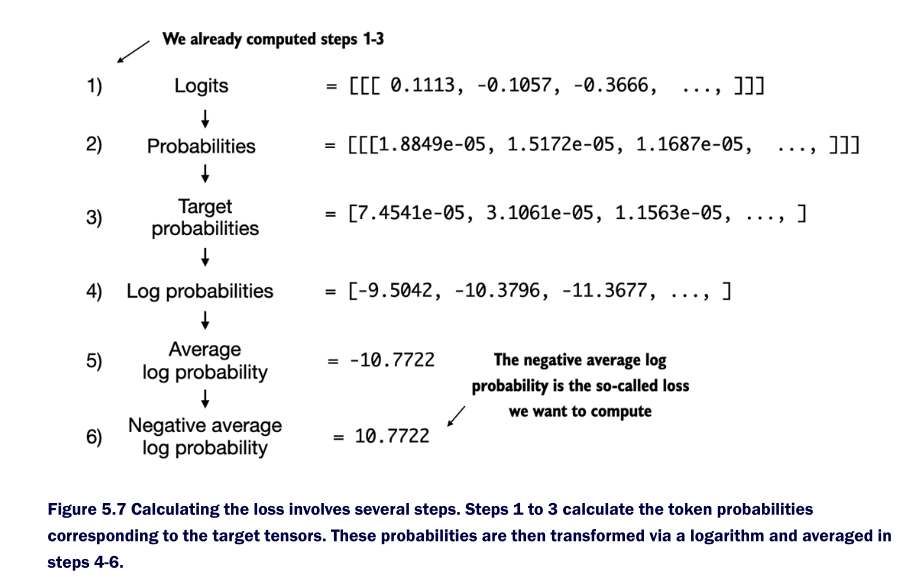

In [52]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.8925, -10.6234, -11.6680, -10.7251, -10.3094, -12.1121])


In [53]:
avg_log_probas = torch.mean(log_probas)
avg_log_probas

tensor(-10.8884)

In [54]:
neg_avg_log_probas = avg_log_probas * -1
neg_avg_log_probas

tensor(10.8884)

### CROSS ENTROPY LOSS

At its core, the cross entropy loss is a popular measure in machine learning and deep
learning that measures the difference between two probability distributions—
typically, the true distribution of labels (here, tokens in a dataset) and the predicted
distribution from a model (for instance, the token probabilities generated by an LLM).


In the context of machine learning and specifically in frameworks like PyTorch, the
cross_entropy function computes this measure for discrete outcomes, which is
similar to the negative average log probability of the target tokens given the model's
generated token probabilities, making the terms cross entropy and negative average
log probability related and often used interchangeably in practice.

In [55]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [56]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [ ]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat) # same as negative average log probability
print(loss)

tensor(10.8884)


### Perplexity

Perplexity is a measure often used alongside cross entropy loss to evaluate the
performance of models in tasks like language modeling. It can provide a more
interpretable way to understand the uncertainty of a model in predicting the next
token in a sequence.


Perplexity measures how well the probability distribution predicted by the model
matches the actual distribution of the words in the dataset. Similar to the loss, a
lower perplexity indicates that the model predictions are closer to the actual
distribution.

Perplexity can be calculated as `perplexity = torch.exp(loss)`, which returns
`tensor(48725.8203)` when applied to the previously calculated loss.


Perplexity is often considered more interpretable than the raw loss value because it
signifies the effective vocabulary size about which the model is uncertain at each
step. In the given example, this would translate to the model being unsure about
which among 47,678 words or tokens in the vocabulary to generate as the next
token.

### 4.1.3 calculating the training and validation set losses